## Exploratory Data Analysis

Loading libraries

In [1]:
import json
import ijson
import logging

import numpy as np

from decimal import Decimal
from pathlib import Path
from typing import List, Tuple

from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *

Setting up Logger

In [2]:
# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

Loading the `ConfigParser` for paths

In [3]:
from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

In [4]:
# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

Loading the Meta Donor DataFrame

In [5]:
meta_donor_csv_pth = PROCESSED_DONORS_GE_PATH / Path("meta_donor.csv")
meta_donor_df = load_df_from_csv(meta_donor_csv_pth)

In [6]:
meta_donor_df.head(5)

,brain_region,gene_id,gene_expression_values
0,4012,2,"[1.58747780630413, 7.567907786636231, 1.495682..."
1,4012,3,"[5.11909080343638, 9.66921569197332, 10.081154..."
2,4012,6,"[1.83564765363665, 1.4949501777457102, 5.94151..."
3,4012,7,"[1.79544247551668, 8.01919162976325, 1.4730663..."
4,4012,9,"[2.20842768312641, 2.53387577054784, 3.1338710..."


Converting the gene_expression_values from a stored string to a list

In [7]:
meta_donor_df["gene_expression_values"]=meta_donor_df["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df["gene_expression_values"][0][0])

1.58747780630413


In [8]:
meta_donor_df.head(5)

,brain_region,gene_id,gene_expression_values
0,4012,2,"[1.58747780630413, 7.567907786636231, 1.495682..."
1,4012,3,"[5.11909080343638, 9.66921569197332, 10.081154..."
2,4012,6,"[1.83564765363665, 1.4949501777457102, 5.94151..."
3,4012,7,"[1.79544247551668, 8.01919162976325, 1.4730663..."
4,4012,9,"[2.20842768312641, 2.53387577054784, 3.1338710..."


Exploring Data Scale

In [9]:
meta_donor_df.describe()

,brain_region,gene_id
count,3.005437e+06,3.005437e+06
mean,5.004835e+03,3.435682e+05
std,1.886995e+03,4.467001e+05
min,4.012000e+03,2.000000e+00
25%,4.136000e+03,1.055500e+04
50%,4.257000e+03,7.751200e+04
75%,4.518000e+03,1.004858e+06
max,1.300500e+04,1.022429e+06


In [10]:
meta_donor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3005437 entries, 0 to 3005436
Data columns (total 3 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   brain_region            int64 
 1   gene_id                 int64 
 2   gene_expression_values  object
dtypes: int64(2), object(1)
memory usage: 68.8+ MB


Using Utility functions to extract some insights about the numbers

In [11]:
# Data Scale
total_number_of_samples = get_total_number_of_samples(meta_donor_df)
logger.info(f"Number of Total Samples: {total_number_of_samples}")

number_of_br = get_total_number_of_br(meta_donor_df)
logger.info(f"Number of Total Brain Regions: {number_of_br}")

number_of_ge_per_br = get_number_of_genes_per_br(meta_donor_df)
logger.info(f"Number of Genes ids per Brain Region: \n{number_of_ge_per_br}")

number_of_samples_per_br = get_number_of_samples_per_br(meta_donor_df)
logger.info(f"Number of Samples per Brain Region:\n{number_of_samples_per_br}")

number_of_samples_per_br_ge = get_number_of_samples_per_br_ge(meta_donor_df)
logger.info(f"Number of Samples per Brain Region-Gene Id pair:\n{number_of_samples_per_br_ge}")

br_ids = get_br_list(meta_donor_df)
logger.info(f"List of Brain Regions:\n{br_ids}")

sample = get_br_ge_sample(meta_donor_df, 4012, 2)
logger.info(f"Sample of Brain Region-Gene Id pair\n{sample}")


Number of Total Samples: 115503888
Number of Total Brain Regions: 103
Number of Genes ids per Brain Region: 
brain_region
4012     29179
4013     29179
4014     29179
4023     29179
4024     29179
         ...  
9598     29179
9614     29179
9677     29179
9698     29179
13005    29179
Name: gene_id, Length: 103, dtype: int64
Number of Samples per Brain Region:
[645601, 1115129, 1056438, 2523713, 2347640, 1936803, 1760730, 880365, 1056438, 1173820, 1232511, 880365, 704292, 762983, 1056438, 1232511, 1115129, 1349893, 939056, 997747, 997747, 1056438, 1173820, 1291202, 1584657, 1643348, 2112876, 2406331, 1936803, 1408584, 1760730, 1173820, 1115129, 645601, 1056438, 1115129, 939056, 1702039, 1467275, 997747, 821674, 762983, 1819421, 2054185, 1056438, 1525966, 1173820, 1467275, 1408584, 1115129, 1232511, 1173820, 1232511, 997747, 939056, 1291202, 880365, 1467275, 2817168, 762983, 645601, 1936803, 410837, 586910, 528219, 469528, 528219, 645601, 1115129, 1056438, 762983, 1173820, 880365, 4108

In [12]:
meta_donor_df.head(5)

,brain_region,gene_id,gene_expression_values,num_gene_expression_values,sample_count
0,4012,2,"[1.58747780630413, 7.567907786636231, 1.495682...",22,22
1,4012,3,"[5.11909080343638, 9.66921569197332, 10.081154...",44,44
2,4012,6,"[1.83564765363665, 1.4949501777457102, 5.94151...",77,77
3,4012,7,"[1.79544247551668, 8.01919162976325, 1.4730663...",22,22
4,4012,9,"[2.20842768312641, 2.53387577054784, 3.1338710...",44,44


### Plotting The number of Brain Region-Gene ID pairs with Sample Sizes Over A Threshold:

Thresholding is done in powers of two so that we can easily divide the sample size by 2

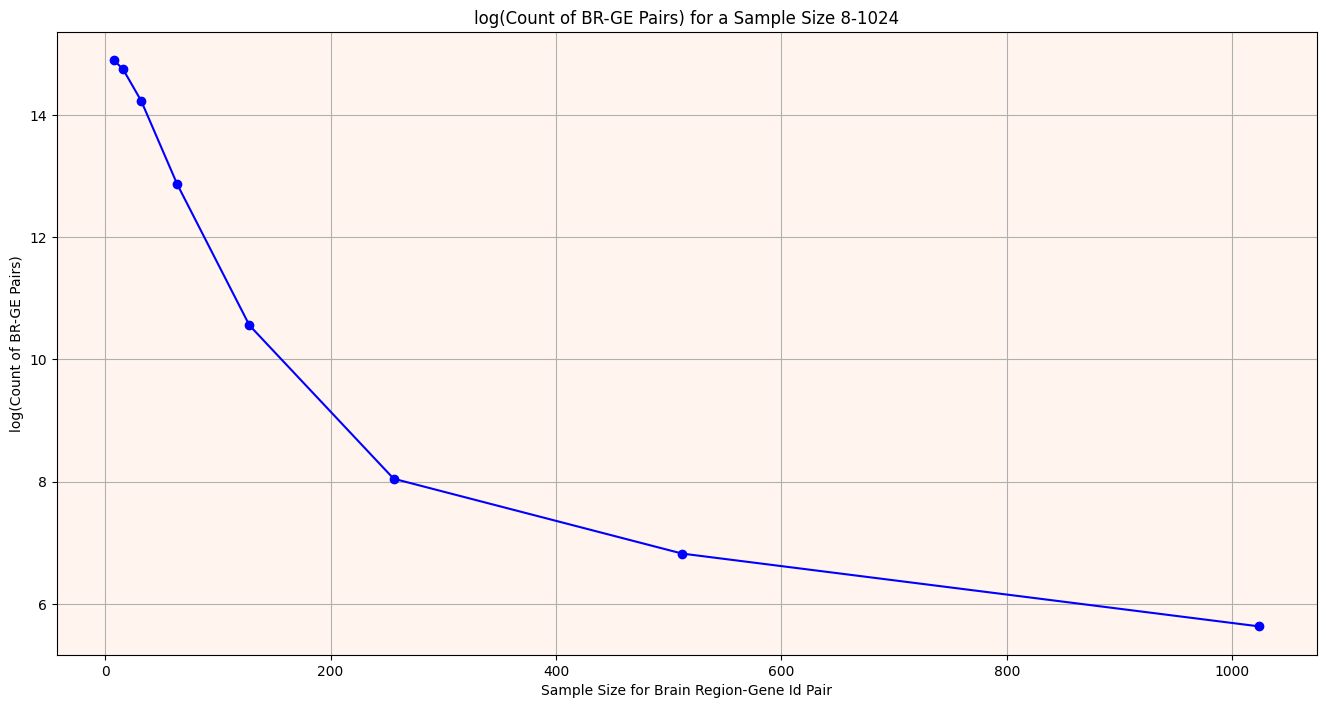

In [14]:
range_with_powers_of_two = [2**i for i in range(3, 11)] 
count_per_threshold= get_br_ge_count_above_sample_size(meta_donor_df, range = range_with_powers_of_two)
plot_values(range_with_powers_of_two,np.log(count_per_threshold), plot_title="log(Count of BR-GE Pairs) for a Sample Size 8-1024", 
            x_title="Sample Size for Brain Region-Gene Id Pair", y_title="log(Count of BR-GE Pairs)", save=True)

In [15]:
_8_count = count_per_threshold[0]
_1024_count = count_per_threshold[len(count_per_threshold)-1]
logger.info(_8_count)
logger.info(_1024_count)
logger.info(len(count_per_threshold))

2952973
278
8


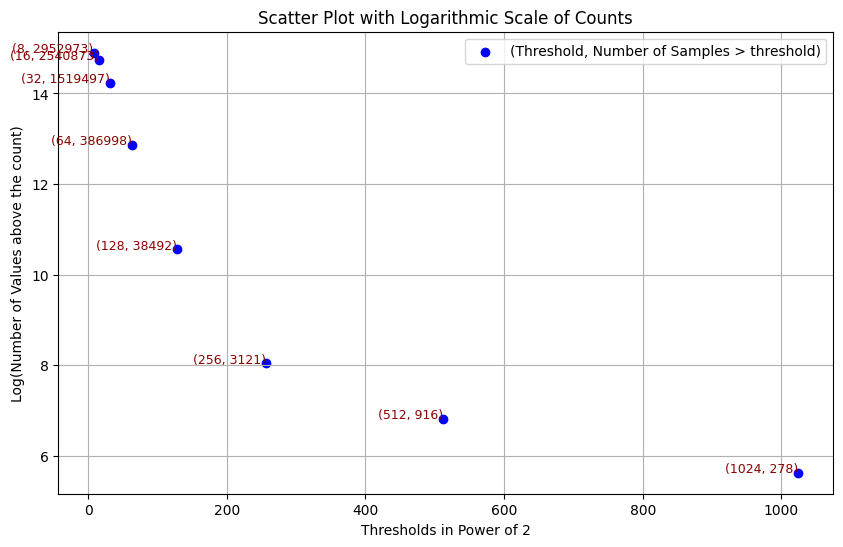

In [45]:
plot_scatter_log(range_with_powers_of_two, count_per_threshold, plot_title= "Scatter Plot with Logarithmic Scale of Counts", 
                 x_title="Thresholds in Power of 2", y_title="Log(Number of Values above the count)", label='(Threshold, Number of Samples > threshold)', save=True)

### Histogram of Samples Per Brain Region

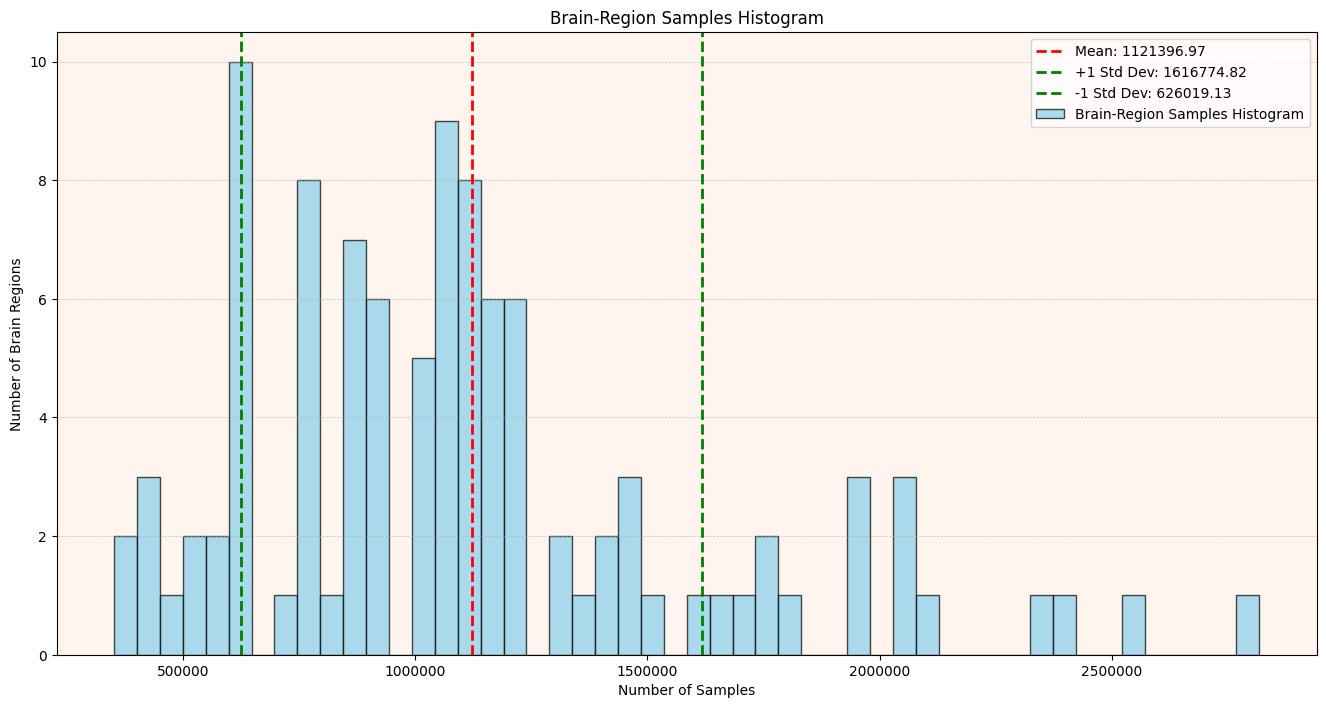

In [26]:
plot_histogram(number_of_samples_per_br, plot_title='Brain-Region Samples Histogram', x_title="Number of Samples", y_title="Number of Brain Regions"
, bins=50, save=True)

### Sanity Checks

In [32]:
logger.info(f"Mean Samples of Brain Region: {total_number_of_samples/len(br_ids)}")
logger.info(f"Total Number of Samples == Sum of Brain Region Sample Counts : {total_number_of_samples == sum(number_of_samples_per_br)}")
logger.info(f"Total Number of Samples == Sum of Sample Counts : {total_number_of_samples == sum(meta_donor_df['sample_count'].tolist())}")

Mean Samples of Brain Region: 1121396.9708737864
Total Number of Samples == Sum of Brain Region Sample Counts : True
Total Number of Samples == Sum of Sample Counts : True
